## An example analysis pipeline using fBOSC, and simulated data

#### We use background data with a nonlinear 1/f spectrum (made in neurodsp), combined with a 10Hz oscillatory burst

In [1]:
%% Add fBOSC and Fieldtrip to your path
fieldtrip_dir = '/Users/rseymoue/Documents/scripts/fieldtrip-20210506';
addpath(fieldtrip_dir);
ft_defaults

fBOSC_dir = '/Users/rseymoue/Documents/GitHub/fBOSC';
cd(fBOSC_dir);

start_fBOSC

Successfully imported fooof from python!


In [2]:
%% Make simulated data with 10hz oscillations embedded within a 
%  non-linear 1/f aperiodic signal

% Load the previously computed non-linear 1/f aperiodic signal
load(fullfile(fBOSC_dir,'validation','synaptic.mat'));

% Settings
ntrials                     = 10;   % Number of trials 
Fs                          = 500;  % Sampling Rate
SNR                         = 40;   % SNR of oscillation
len_of_trial                = 20;   % Length of each trial in s

% Trim aperiodic data down to size of ntrials*len_of_trial
synaptic                   = synaptic(1:ntrials,[1:(len_of_trial*Fs)]);

% HP-Filter @ 1Hz, like in typical EEG/MEG studies
for n = 1:ntrials
    synaptic(n,:) = ft_preproc_highpassfilter(synaptic(n,:), Fs,...
        1, 3);
end

% Simulate an alpha oscillation in the middle of the trial for 6s
cfg                         = [];
cfg.freq                    = 10; % Simulated a 10Hz oscillation
cfg.amplitude               = SNR; % SNR of the simulated oscillation
cfg.cycles                  = 6/(1/10); % How many cycles: For 6s
cfg.time                    = 20; % 20s of simulated data
cfg.trial                   = ntrials; % How many 'trials'?
[aperiodic_out_alpha,...
    osc_alpha,... 
    data_alpha,~]...
                            = sim_fBOSC(cfg,Fs,synaptic);


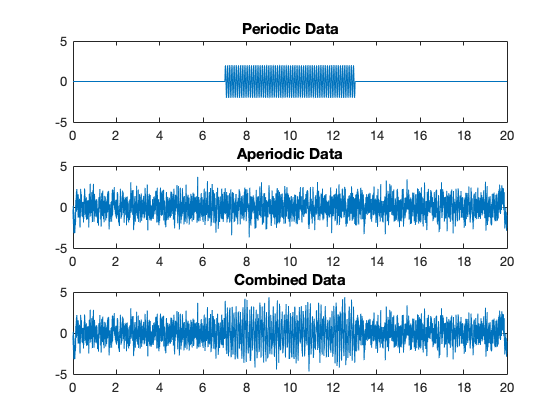

In [4]:
%% Plot the aperiodic and periodic data separately
figure; subplot(3,1,1);plot(data_alpha.time{1},osc_alpha(1,:));
title('Periodic Data');
subplot(3,1,2);plot(data_alpha.time{1},aperiodic_out_alpha(1,:));
title('Aperiodic Data');
subplot(3,1,3);plot(data_alpha.time{1},data_alpha.trial{1});
title('Combined Data');

In [5]:
%% Set-up fBOSC parameters

% general setup
cfg.fBOSC.F                 = 2.^[1:.125:5.4];
cfg.fBOSC.wavenumber        = 6;           % wavelet family parameter (time-frequency tradeoff)
cfg.fBOSC.fsample           = Fs;         % current sampling frequency of EEG data

% padding
cfg.fBOSC.pad.tfr_s         = 0.1;      % padding following wavelet transform to avoid edge artifacts in seconds (bi-lateral)
cfg.fBOSC.pad.detection_s   = .1;       % padding following rhythm detection in seconds (bi-lateral); 'shoulder' for BOSC eBOSC.detected matrix to account for duration threshold
cfg.fBOSC.pad.background_s  = 0.1;      % padding of segments for BG (only avoiding edge artifacts)

% fooof parameters - fit with fixed line or allow a knee
cfg.fBOSC.fooof.aperiodic_mode    = 'knee';

% threshold settings
cfg.fBOSC.threshold.duration	= repmat(3, 1, numel(cfg.fBOSC.F)); % vector of duration thresholds at each frequency (previously: ncyc)
cfg.fBOSC.threshold.percentile  = .99;                              % percentile of background fit for power threshold

% episode post-processing
cfg.fBOSC.postproc.use      = 'no';        % Post-processing turned off for now

% general processing settings
cfg.fBOSC.channel           = [1]; % select posterior channels (default: all)
cfg.fBOSC.trial             = []; % select trials (default: all)
cfg.fBOSC.trial_background  = []; % select trials for background (default: all)


In [6]:
%% Run fBOSC
clear fBOSC
[fBOSC, cfg] = fBOSC_wrapper(cfg, data_alpha);


Channel 1/1: chan1
Calculating mean of all TFRs


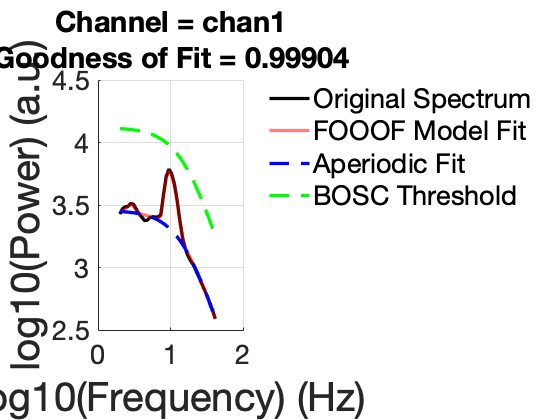

In [7]:
%% Plot the Results of the 1/f fit
cfg.log_freqs = 1;
cfg.plot_old  = 0;
fBOSC_fooof_plot(cfg,fBOSC)

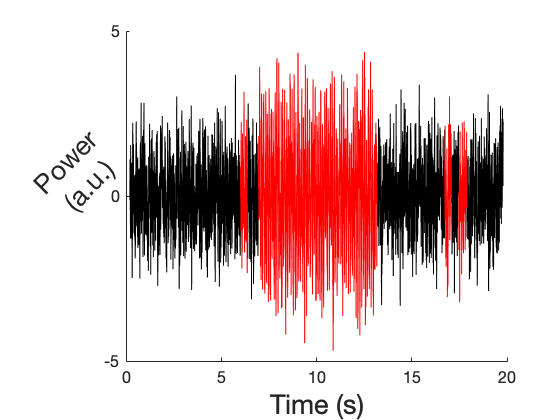

In [8]:
%% Plot the time-series in black alongside detected bursts in red

% ONLY PLOT FIRST TRIAL

figure;
set(gcf,'Position',[100 100 1200 600]); hold on;

indTrial = 1;

% This is the crucial bit of code that gets the detected time(s) of
% alpha bursts from each trial
tmpDetected = single(squeeze(nanmean(fBOSC.detected(1, ...
    indTrial,cfg.fBOSC.F > 8 & cfg.fBOSC.F < 13,:),3))>0); ...
    tmpDetected(tmpDetected==0) = NaN;

origData = data_alpha.trial{indTrial}(cfg.fBOSC.channel(1),...
    cfg.fBOSC.pad.total_sample+1:end-cfg.fBOSC.pad.total_sample);

origData_time = data_alpha.time{indTrial}(...
    cfg.fBOSC.pad.total_sample+1:end-cfg.fBOSC.pad.total_sample);

% Plot
plot(origData_time,squeeze(origData), 'k');
plot(origData_time,squeeze(origData).*tmpDetected', 'r');
set(findall(gcf,'-property','FontSize'),'FontSize',12)
ylabel({'Power';'(a.u.)'},'FontSize',20);
set(get(gca,'YLabel'),'Rotation',45)
xlabel('Time (s)','FontSize',20);




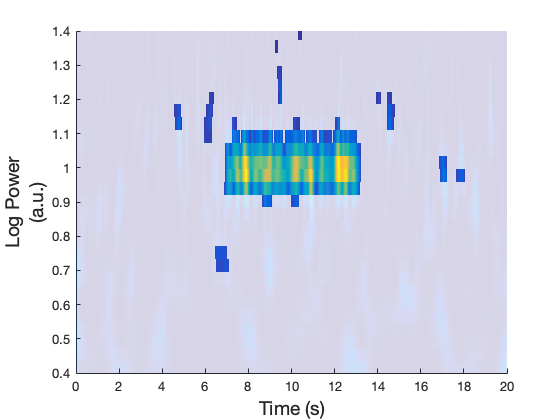

In [9]:
%% Let's plot the same thing but using TFRs

% Compute TFRs
TFR = [];
for indTrial = 1:length(data_alpha.trial)
    TFR.trial{indTrial} = BOSC_tf(data_alpha.trial{indTrial},...
        cfg.fBOSC.F,cfg.fBOSC.fsample,cfg.fBOSC.wavenumber);
end; clear indTrial


% ONLY PLOT FIRST TRIAL

figure;
set(gcf,'Position',[100 100 1200 900]);

indTrial = 1;

TFR_ = TFR.trial{indTrial}(:,101:9900); % Account for padding

% This is the crucial bit of code 
tmpDetected = logical(squeeze(fBOSC.detected(1,indTrial,:,:)));

% Plot
imagesc('YData',log10(cfg.fBOSC.F),'XData',data_alpha.time{1},'CData',...
    TFR_,'AlphaData', tmpDetected); hold on;
imagesc('YData',log10(cfg.fBOSC.F),'XData',data_alpha.time{1},'CData',...
    TFR_,'AlphaData', 0.2);
set(gca,'YDir','normal');
xlim([0 20]);
ylim([0.4 1.4]);
set(gca,'FontSize',10);
ylabel({'Log Power';'(a.u.)'},'FontSize',14);
xlabel('Time (s)','FontSize',14);
    
